# SDFusion: Unconditional generation and shape completion.

In [1]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
# import libraries
import numpy as np
from termcolor import colored, cprint
# for display
from IPython.display import Image as ipy_image
from IPython.display import display

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from datasets.dataloader import CreateDataLoader, get_data_generator
from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

In [3]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionOpt

seed = 2023
opt = SDFusionOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionTestOption initialized.


In [4]:
# initialize SDFusion model
ckpt_path = 'saved_ckpt/sdfusion-snet-all.pth'
dset="snet"
opt.init_model_args(ckpt_path=ckpt_path)
opt.init_dset_args(dataset_mode=dset)
SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: saved_ckpt/vqvae-snet-all.pth
[*] weight successfully load from: saved_ckpt/sdfusion-snet-all.pth
[*] setting ddim_steps=200
[*] Model has been created: SDFusion-Model
[*] "SDFusion-Model" loaded.


## 1. Unconditional Generation

Data shape for DDIM sampling is (6, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s]


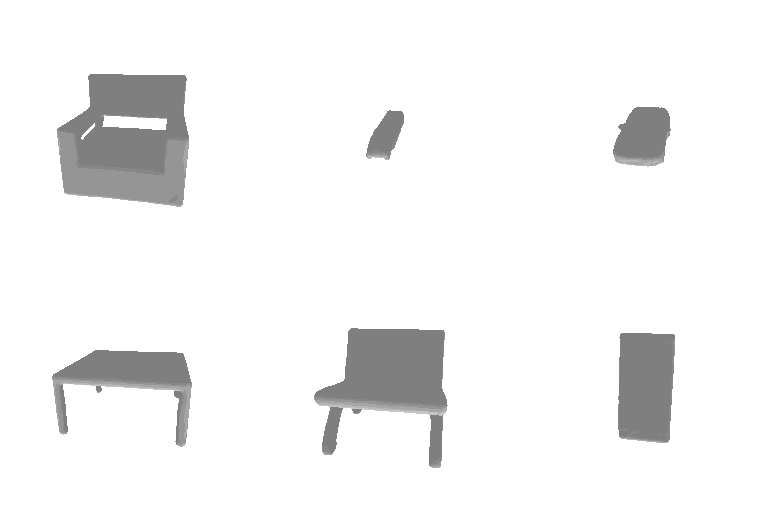

In [5]:
# unconditional generation
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

ngen = 6
ddim_steps = 100
ddim_eta = 0.

sdf_gen = SDFusion.uncond(ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta)

mesh_gen = sdf_to_mesh(sdf_gen)

# vis as gif
gen_name = f'{out_dir}/uncond.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

for name in [gen_name]:
    display(ipy_image(name))

## 2. Shape Completion

We first prepare the input shape here. Use the xyz range `(-1 ~ 1)` to specify the missing region `(x_min, x_max, y_min, y_max, z_min, z_max)`.
The orientations are (suppose we look at the shape):
- x: left to right
- y: bottom to top
- z: back to front

For instance, setting `y_min, y_max = 0, 1` gives us the top half of the shape.

In [6]:
# initialize dataset
dataroot = '/data01/data'
dset = 'snet'
opt.init_dset_args(dataroot=dataroot, dataset_mode=dset)
_, test_dl, _ = CreateDataLoader(opt)
test_ds = test_dl.dataset
test_dg = get_data_generator(test_dl)

[*] 0 samples for airplane (02691156).
[*] 0 samples for bench (02828884).
[*] 0 samples for cabinet (02933112).
[*] 0 samples for car (02958343).
[*] 0 samples for chair (03001627).
[*] 0 samples for display (03211117).
[*] 0 samples for lamp (03636649).
[*] 0 samples for speaker (03691459).
[*] 0 samples for rifle (04090263).
[*] 0 samples for sofa (04256520).
[*] 0 samples for table (04379243).
[*] 0 samples for phone (04401088).
[*] 0 samples for watercraft (04530566).
[*] 0 samples loaded.
[*] 0 samples for airplane (02691156).
[*] 0 samples for bench (02828884).
[*] 0 samples for cabinet (02933112).
[*] 0 samples for car (02958343).
[*] 0 samples for chair (03001627).
[*] 0 samples for display (03211117).
[*] 0 samples for lamp (03636649).
[*] 0 samples for speaker (03691459).
[*] 0 samples for rifle (04090263).
[*] 0 samples for sofa (04256520).
[*] 0 samples for table (04379243).
[*] 0 samples for phone (04401088).
[*] 0 samples for watercraft (04530566).
[*] 0 samples loaded.


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
from utils.demo_util import get_partial_shape
from utils.util_3d import combine_meshes

# 987: sofa
data_ix = 987
test_data = test_ds[data_ix]

shape = test_data['sdf'].unsqueeze(0).to(device)

# specify input range. [min, max]: [-1, 1]
# default setting: given top shape.
x_min, x_max = -1, 1
y_min, y_max = 0, 1
z_min, z_max = -1, 1
xyz_dict = {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}

# visualize input and partial shape
ret = get_partial_shape(shape, xyz_dict)
shape_part, shape_missing = ret['shape_part'], ret['shape_missing']

mesh_part = sdf_to_mesh(shape_part)
mesh_missing = sdf_to_mesh(shape_missing, color=[1, .6, .6])

# print(mesh_part)
# print(mesh_missing)

mesh_comb = combine_meshes(mesh_part, mesh_missing)
# rend_mesh_comb = render_mesh(SDFusion.renderer, mesh_comb, norm=False)

# save it
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)
sc_input_name = f'{out_dir}/shape_comp_input.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_comb, nrow=3, out_name=sc_input_name)

for name in [sc_input_name]:
    display(ipy_image(name))

print('Red cuboid: missing region')

In [ ]:
# shape completion
ngen = 6
ddim_steps = 100
ddim_eta = 0.
output_shape_comp = SDFusion.shape_comp(shape, xyz_dict, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta)

mesh_shape_comp = sdf_to_mesh(output_shape_comp)

# vis as gif
sc_output_name = f'{out_dir}/shape_comp_output.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_shape_comp, nrow=3, out_name=sc_output_name)

for name in [sc_input_name, sc_output_name]:
    display(ipy_image(name))

print('[*] Red cuboid: missing region')